## Avoiding Eutrophication Using Deep Learning Models


In [124]:
# Import required libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K

#### Establishing data based on previous EDA

In [149]:
# Import the data

Secchi_df = pd.read_csv('Secchi_Data.csv')
Use_df = pd.read_csv('Use_Data.csv')
Productivity_df = pd.read_csv('Productivity_Data.csv')
Hydrolakes_df = pd.read_csv('Hydrolakes_Data.csv')

# Dropping the columns we don't care about
Secchi_df = Secchi_df.drop(columns=['row_id', 'name', 'meas_location', 'sec_flag', 'year'])
Use_df = Use_df.drop(columns=['row_id', 'name', 'comment'])
Productivity_df = Productivity_df.drop(columns=['row_id', 'name', 'stratum', 'meas_location', 'tp_ugl', 'tp_flag', 'tn_ugl', 'tn_flag', 'doc_flag', 'chla_flag', 'comment', 'year'])
Hydrolakes_df = Hydrolakes_df.drop(columns=['row_id', 'name', 'hylak_id', 'shore_len_km', 'dis_avg_ms3'])

# Make a single dataframe

df = Secchi_df.merge(Use_df, on='lake_id', how='outer') \
              .merge(Productivity_df, on=['lake_id', 'date'], how='outer') \
              .merge(Hydrolakes_df, on=['lake_id'], how='outer')
              

# Cleaning the dataset
df = df.dropna(subset=['secchi', 'perag', 'depth', 'area_km2', 'doc_mgl', 'chla_ugl'])

# Displa head
df.head()

C:\conda_tmp\ipykernel_18472\3214712678.py:5: DtypeWarning: Columns (5,8,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  Productivity_df = pd.read_csv('Productivity_Data.csv')


,lake_id,date,secchi,perag,perdev,perwater,perfor,perwet,pergrass,pershrub,depth,doc_mgl,chla_ugl,area_km2,mean_depth_m,res_time_days,elevation_m,wshd_area_km2
2325,1,2002-03-04,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,0.8,2.8,4.5,83.77,34.0,611.1,1.0,1488.1
2330,1,2002-03-04,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,59.4,2.9,2.8,83.77,34.0,611.1,1.0,1488.1
2332,1,2002-03-04,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,0.8,2.8,4.5,83.77,34.0,611.1,1.0,1488.1
2337,1,2002-03-04,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,59.4,2.9,2.8,83.77,34.0,611.1,1.0,1488.1
2341,1,2002-04-01,4.3,0.84,48.97,2.2,41.23,2.0,0.76,3.76,1.0,3.0,16.1,83.77,34.0,611.1,1.0,1488.1


The initial dataset was used to show the effects of climate change on dissolved oxygen in lakes, the conclusion of the inital data collection being that there was a reduction over time. That conclusion was drawn from disolved organic carbon among other factors looked at in this model increasing over time. To train a model that determines the effect of farmland on this data we therefore have to decide what to do with the time series nature of the model. 

Our options are
- Ignore the date
- Use most recent datapoints only
- Average values for each lake

The exploratory data analysis revealed that the increase over all lakes seems to be relatively small in terms of total change. Note that the slope is next to zero because we are working with a very small value over a long period of time and some lakes cause an offset. Check out individual lakes to better see the increase in the total ammount of disolved organic carbon. Percent change and variability are actually what scientists are worried about with the effects of climate change but for the sake of the model thats not exactly what we care about. We care about variablitiy in that outliers and the increase in how erratic the data is holds importance for the model. Some lakes dip below their original values or have massive random spikes; we can't just grab the most recent data or average over time because it is important for the model to capture a lakes variability in order to build a more comprehensive model. Thus, it makes the most sense to drop the date column and the lake_id column to make a more general purpose model that can make estimates for any lake it is given data for.

In [172]:
df = df.drop(columns=['lake_id','date'])
df.head()

,secchi,perag,perdev,perwater,perfor,perwet,pergrass,pershrub,depth,doc_mgl,chla_ugl,area_km2,mean_depth_m,res_time_days,elevation_m,wshd_area_km2
2325,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,0.8,2.8,4.5,83.77,34.0,611.1,1.0,1488.1
2330,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,59.4,2.9,2.8,83.77,34.0,611.1,1.0,1488.1
2332,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,0.8,2.8,4.5,83.77,34.0,611.1,1.0,1488.1
2337,3.8,0.84,48.97,2.2,41.23,2.0,0.76,3.76,59.4,2.9,2.8,83.77,34.0,611.1,1.0,1488.1
2341,4.3,0.84,48.97,2.2,41.23,2.0,0.76,3.76,1.0,3.0,16.1,83.77,34.0,611.1,1.0,1488.1


In [128]:
len(df)

7377

In [130]:
# Custom loss function, mean absoulte error modified to bias towards enviornmentalism

def custom_loss(delta): # Delta should be > 1 to punish more
    def loss(y_true, y_pred):
        error = y_true - y_pred 
        is_below_margin = error < 0 # If we predict a higher secchi value, we want to punish it more
        #small_error_loss = K.abs(error)
        #large_error_loss = delta * K.abs(error)
        small_error_loss = K.square(error)
        large_error_loss = delta * K.square(error)
        return K.mean(K.switch(is_below_margin, large_error_loss, small_error_loss), axis=-1)
    return loss


In [177]:
# Split features and target variable
X = df.drop('secchi', axis=1)
y = df['secchi']

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=37)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Grabbing this for later
Random_lake = X.iloc[100]

# Convert y to a numpy array
y = np.array(y)

# Initialize lists to store the results from each fold
train_losses = []
val_losses = []

# Loop through each fold
for train_index, val_index in kf.split(X_scaled):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Design the neural network
    model = Sequential([
        Dense(64, activation='elu', input_shape=(X_train_fold.shape[1],)),
        Dense(64, activation='elu'),
        Dense(1)  # Output layer with a single neuron for regression
    ])

    # Compile the model
    model.compile(optimizer='adam', loss=custom_loss(delta=2.50))

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=30, validation_data=(X_val_fold, y_val_fold))
    
    # Evaluate the model on training and validation data
    train_loss = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    
    # Append losses to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Calculate average losses across folds
avg_train_loss = np.mean(train_losses)
avg_val_loss = np.mean(val_losses)

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)


Epoch 1/50


c:\Users\Preston Waters\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 13.9896 - val_loss: 3.6984
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4815 - val_loss: 3.5612
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4456 - val_loss: 3.5628
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4773 - val_loss: 3.6952
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3766 - val_loss: 3.4914
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2459 - val_loss: 3.5097
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5111 - val_loss: 3.5246
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5588 - val_loss: 3.4291
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2728 - val_loss: 3.5707
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3755 - val_loss: 3.3822
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3182 - val_loss: 3.4100
Epoch 12/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3

In [176]:
# Grabbing new test data for further evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [133]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [134]:
# Compare predictions with actual values:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': predictions.flatten()})
print(comparison.head())

       Actual  Predicted
43377    5.35   5.147142
50285    4.90   5.585590
44546    3.40   4.221447
49371    4.60   3.806132
22441    2.40   1.727856


In [135]:
comparison['Percent Error'] = (abs(comparison['Actual'] - comparison['Predicted']) / comparison['Actual']) * 100
mean_percent_error = comparison['Percent Error'].mean()

print("Absolute Mean Percent Error:", mean_percent_error)

Absolute Mean Percent Error: 22.794307666053374


In [136]:
comparison['Percent Error'] = ((comparison['Actual'] - comparison['Predicted']) / comparison['Actual']) * 100
mean_percent_error = comparison['Percent Error'].mean()

print("Mean Percent Error:", mean_percent_error)

Mean Percent Error: 1.1615430065367869


In [138]:
count_predicted_greater_than_actual = (comparison['Predicted'] > comparison['Actual']).sum()
total_predictions = len(comparison)

print("Number of times Predicted is greater than Actual:", count_predicted_greater_than_actual)
print("Total number of predictions:", total_predictions)
print("Percent of predictions clearer than actual:", round((count_predicted_greater_than_actual / total_predictions)*100, 2))

Number of times Predicted is greater than Actual: 881
Total number of predictions: 2214
Percent of predictions clearer than actual: 39.79


#### Using the model to predict values for an arbitrary lake

Now that we have a model that predicts the secchi value from data about the lake, we can use this to examine how much human activity, specifically converting parts of a lake's watershed into farmland, a lake can handle.

The initial idea was to frame it as an optimization problem and solve it through gradient descent. (Technically gradient ascent.) Basically, talk to the enviornmental scientists to get an idea of the minimum secchi value a lake's ecosystem could handle. Then we take the current composition of the watershed area and it's secchi value as our initial values. We can then use the model's predictions to power our cost function, we say yay to high argriculture and nay to secchi values under the target. This way, the steps that adjust the various percentage compositions of the watershed should be motivated to increase argicultural area as much as possible while still keeping lakes clean.

This sounds really clever but ignores a massive issue. Firstly, we can't really just make more forest, grassland, etc and secondly, this ignores that the percentages must add up to 100. Without these constraints, there's nothing stopping us from having over 9000% forest to enable a huge farm near the lake. We have to provide the constraints that certain land types strictly decrease and that their percentages must add up to 100. The first one is easy, we just tack on a huge penalty to the cost function for increasing anything that shouldn't increase, no problem there. Well, no problem if we avoid getting trapped at local minimums though that can always be handled with more starting points and various step sizes at the cost of computation time.

How about keeping all the percentages adding up to 100? In a 1987 paper "Constrained Differential Optimization", Platt and Barr provide a solution, the basic differential multiplier method.

The method claims that for a Lagrangian: L(x, b) = f(x) + b g(x)

Essentially, "doing gradient descent on x while doing gradient 'ascend' on b, you will finally converge to a stationary point of L(x, b), which is a local minima of f(x) under the constraint g(x)=[100]. Penalty method could also be combined to make converge faster and stabler (which the authors call the modified differential multiplier method)."

"Many optimization models of neural networks need constraints to restrict the space of outputs to a subspace which satisfies external criteria. Optimizations using energy methods yield "forces" which act upon the state of the neural network. The penalty method, in which quadratic energy constraints are added to an existing optimization energy, has become popular recently, but is not guaranteed to satisfy the constraint conditions when there are other forces on the neural model or when there are multiple constraints. In this paper, we present the basic differential multiplier method (BDMM), which satisfies constraints exactly; we create forces which gradually apply the constraints over time, using "neurons" that estimate Lagrange multipliers."

https://stackoverflow.com/questions/12284638/gradient-descent-with-constraints-lagrange-multipliers
https://papers.nips.cc/paper/1987/hash/a87ff679a2f3e71d9181a67b7542122c-Abstract.html


Okay wow, awesome, seems like we have this all figured out, through clever cost function design and multiple simultaneous ascents and descents we can build a model to optimize farmland. Very clever, also unfortunately somewhat pointless given the nature of the data and the nature of the real world. Firstly, we have no specific data on where any of the land actually is in relation to the lake, are the forests all together or are they in patches? Most often, we want to build a square farm so we wouldn't just patchwork it around the area to fit what a computer says is best. So, this initial suggestion of an optimizer is technically interesting in terms of implementation, thus the though experiment for personal satisfaction, but not usable given the limited data we have.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


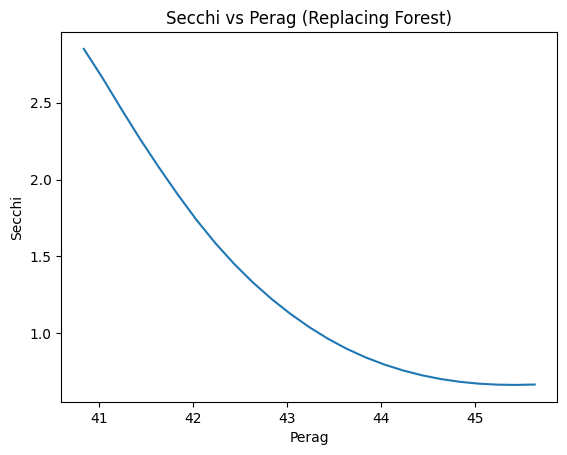

In [195]:
scaler = StandardScaler()


# Define lists to store perag, perfor, and secchi values for plotting
perag_values = []
perfor_values = []
secchi_values = []

Random_lake_copy = Random_lake.copy()  # Create a copy of the DataFrame


# Fit the scaler to the original data once
scaler.fit(Random_lake_copy.to_frame().transpose())

# Loop through iterations
for _ in range(25):
    
    # Transform the new data using the fitted scaler
    Random_lake_scaled = scaler.transform(Random_lake_copy.to_frame().transpose())
    
    # Predict secchi using the scaled data
    secchi = model.predict(Random_lake_scaled)[0][0]

    # Append values to lists
    perag_values.append(Random_lake_copy['perag'])
    perfor_values.append(Random_lake_copy['perfor'])
    secchi_values.append(secchi)

    # Update perag and perfor
    Random_lake_copy['perag'] += 0.2
    Random_lake_copy['perfor'] -= 0.2


# Plot the results
plt.plot(perag_values, secchi_values)
plt.xlabel('Perag')
plt.ylabel('Secchi')
plt.title('Secchi vs Perag (Replacing Forest)')
plt.show()
